## Climate Analysis and Exploration
----
### Perform three analyses. 
1. Precipitation analysis for the last 12 months of precipitation data for all weather stations.
2. Station analysis for the most active stations and the last 12 months of temperature observation data (tobs).
3. Temperature analysis for the min, avg, and max temperature of a trip to Hawaii between 3-15 days. 

In [1]:
# Import SQLAlchemy `automap` and other dependencies here

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine,inspect, func, desc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

In [2]:
# Create an engine for the `hawaii.sqlite` database
### BEGIN SOLUTION
engine = create_engine('sqlite:///hawaii.sqlite', echo=False)

# Declare a Base using `automap_base()`
Base = automap_base()

In [3]:
# Reflect Database into ORM classes
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'stations']

In [4]:
# Save a reference to the measurenment table as 'Measurement'
Measurement = Base.classes.measurement
# Save a reference to the station table as 'Station'
Station = Base.classes.stations

## Precipitation Analysis

In [5]:
#Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [6]:
# Create a database session object
session = Session(engine)

In [7]:
# Get the last date of entry
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Get the date 365 days from the last date.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Retrieve the last 12 months of precipitation data
one_yr_prcp = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > first_date).\
                        order_by(Measurement.date).all()

In [8]:
# Load the results into a pandas dataframe.

precipitation_df = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Reset the index to the 'Date'
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()

,Date,Prcp
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,0.00
2016-08-24,2016-08-24,1.22


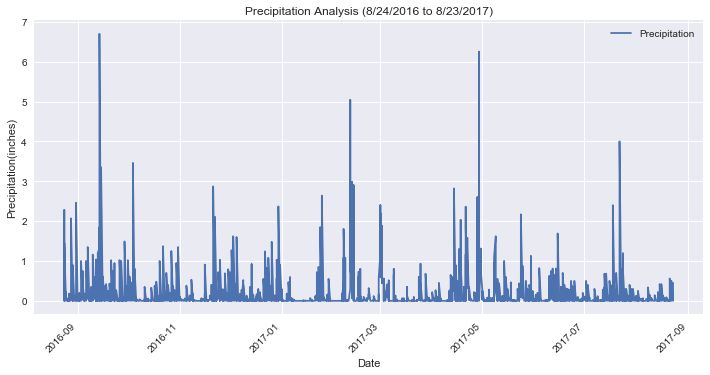

In [9]:
# Plot the dataframe as a horizontal bar chart using pandas plotting

precipitation_df.plot('Date', 'Prcp',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [10]:
# Summary statistics for the percipitation df. 
precipitation_df.describe()

,Prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


### The above data is the precipitation from each weather station for each date.  The data should be graphed for the average amount of the rain for each date from all the weather stations. See the next graph.

In [11]:
# Load the results into a pandas dataframe.

precipitation_sum = pd.DataFrame(one_yr_prcp, columns=['Date', 'Prcp'])

#Change the date to a datetime format.
precipitation_sum['Date'] = pd.to_datetime(precipitation_sum['Date'], format='%Y/%m/%d')

#precipitation_df.set_index('Date').head()
# Get the total for each station for each date and set the index as the date.
precipitation_totals = precipitation_sum.pivot_table(precipitation_sum, index=['Date'], aggfunc='mean')
precipitation_totals.head()

,Prcp
Date,
2016-08-24,1.332857
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.053333
2016-08-28,0.516667


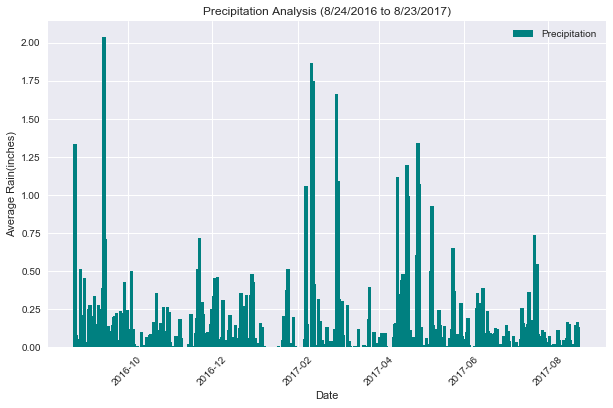

In [24]:
# Plot the dataframe as a horizontal bar chart using pandas plotting

plt.bar(precipitation_totals.index, precipitation_totals["Prcp"], width=2.5, color="teal")
plt.rcParams["figure.figsize"] = [12,6]
plt.xlabel("Date")
plt.ylabel("Average Rain(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [13]:
# Summary statistics for the percipitation df. 
precipitation_totals.describe()

,Prcp
count,365.000000
mean,0.156103
std,0.275657
min,0.000000
25%,0.008571
50%,0.065000
75%,0.175714
max,2.040000


## Station Analysis

In [14]:
# Find the total number of stations
# Getting them from the stations table.
station_count = session.query(Station.station).count()
print("There are {} stations.".format(station_count))

# Or, getting them from the measurement table.
station_count_alt = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are",station_count_alt, "stations.")

There are 9 stations.
There are 9 stations.


In [15]:
# List the most active stations and their observation counts in descending order.
station_tobs = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    join(Station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).all()

print("The stations with the highest number of observations in descending order are:")
print()
for station, name, count in station_tobs:
    print("Station:",station, "in",name,"with",count, "observations.")

The stations with the highest number of observations in descending order are:

Station: USC00519281 in WAIHEE 837.5, HI US with 2772 observations.
Station: USC00519397 in WAIKIKI 717.2, HI US with 2724 observations.
Station: USC00513117 in KANEOHE 838.1, HI US with 2709 observations.
Station: USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US with 2669 observations.
Station: USC00516128 in MANOA LYON ARBO 785.2, HI US with 2612 observations.
Station: USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US with 2202 observations.
Station: USC00511918 in HONOLULU OBSERVATORY 702.2, HI US with 1979 observations.
Station: USC00517948 in PEARL CITY, HI US with 1372 observations.
Station: USC00518838 in UPPER WAHIAWA 874.3, HI US with 511 observations.


In [16]:
# Which station has the highest number of observations?
station_max_obs = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    join(Station).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).first()
    
print("Station {}".format(station_max_obs[0]),"in {}".format(station_max_obs[1]),
      "has the most obesrvations, with {}".format(station_max_obs[2]))

Station USC00519281 in WAIHEE 837.5, HI US has the most obesrvations, with 2772


In [17]:
# Retrieve the last 12 months of temperature observation data (tobs).

station_12m_obs = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
                    join(Station).\
                    group_by(Measurement.station).\
                    filter(Measurement.date > first_date).\
                    order_by(func.count(Measurement.tobs).desc()).all()

busiest_station = station_12m_obs[0][0:2]   

print("The stations with the highest number of observations in the last 12 months in descending order are:")
print()
for station, name, count in station_12m_obs:
    print("Station:",station, "in",name,"with",count, "observations.")

The stations with the highest number of observations in the last 12 months in descending order are:

Station: USC00519397 in WAIKIKI 717.2, HI US with 360 observations.
Station: USC00519281 in WAIHEE 837.5, HI US with 351 observations.
Station: USC00516128 in MANOA LYON ARBO 785.2, HI US with 348 observations.
Station: USC00513117 in KANEOHE 838.1, HI US with 342 observations.
Station: USC00519523 in WAIMANALO EXPERIMENTAL FARM, HI US with 336 observations.
Station: USC00514830 in KUALOA RANCH HEADQUARTERS 886.9, HI US with 304 observations.
Station: USC00517948 in PEARL CITY, HI US with 182 observations.


### The station that was the busiest for the last 12 months was USC00519397, WAIKIKI 717.2, HI US

In [18]:
# Filter by busiest station for the 12 months.
busy_station_obs = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest_station[0]).\
    filter(Measurement.date > first_date).\
    order_by(Measurement.date).all()

# Put them in a df. 
tobs_df = pd.DataFrame(busy_station_obs, columns=['Date', 'Tobs'])
tobs_df.head()

,Date,Tobs
0,2016-08-24,79
1,2016-08-25,80
2,2016-08-26,79
3,2016-08-27,77
4,2016-08-28,78


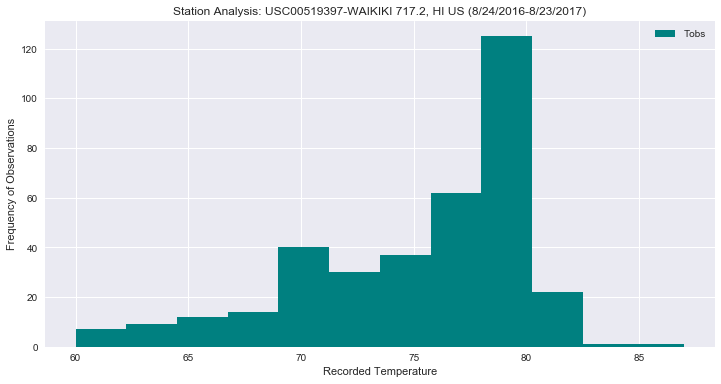

In [19]:
plt.hist(tobs_df['Tobs'],bins=12, color="teal")
plt.rcParams["figure.figsize"] = [10,6]
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency of Observations")
plt.title("Station Analysis: USC00519397-WAIKIKI 717.2, HI US (8/24/2016-8/23/2017)")
plt.legend(["Tobs"])
plt.show()

## Temperature Analysis

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates for the vacation.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
    for Tmin, Tmax, Tavg in query:
        print("From", start_date, "to", end_date, "the minimum temperature is",
              Tmin,'\u00b0'"F, the maximum temperature is", Tmax,'\u00b0'"F, and the average temeperature is",
              "{0:.1f}".format(round(Tavg,1)),'\u00b0'"F.")

calc_temps('2017-06-28', '2017-07-07')

From 2017-06-28 to 2017-07-07 the minimum temperature is 74 °F, the maximum temperature is 87 °F, and the average temeperature is 77.7 °F.


In [21]:
start_date = '2017-06-28'
end_date = '2017-07-07'
vacay_query = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
# Load the results into a pandas dataframe.

vacay_temps = pd.DataFrame(vacay_query, columns=['Date', 'Tobs'])
vacay_temps.head()

,Date,Tobs
0,2017-06-28,79
1,2017-06-29,79
2,2017-06-30,75
3,2017-07-01,80
4,2017-07-02,80


In [22]:
# Check to see if the min, max and avg temp are correct.
vacay_temps.describe()

,Tobs
count,60.000000
mean,77.716667
std,2.511611
min,74.000000
25%,76.000000
50%,77.000000
75%,79.250000
max,87.000000


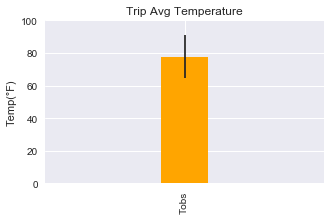

In [23]:
avg_temp = vacay_temps.mean()
temp_diff = (vacay_temps["Tobs"].max()-vacay_temps["Tobs"].min())


p = avg_temp.plot(legend=False,kind="bar",color="orange",yerr=temp_diff, width=0.1, figsize=(5,3))
p.set_title("Trip Avg Temperature")
p.set_ylabel("Temp(°F)")
p.set_ylim(0,100)
plt.show()